# Import Libraries & Settings 

In [1]:
! pip install kaggle


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install pmdarima


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install ThymeBoost


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#Deal with dataframes and equations
import pandas as pd
import numpy as np
import scipy as sp

# Access Kaggle
import os
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

# Deal with graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Stationary
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# PmdArima -> Optimizer
import pmdarima as pm
from ThymeBoost import ThymeBoost as tb

#Sklearn metrics
from sklearn.metrics import mean_squared_error

#Create a table
from tabulate import tabulate

# Deal with dates
from datetime import date

from pprint import pprint



In [5]:
api = KaggleApi()
api.authenticate()

In [6]:
pd.options.display.float_format = "{:,.2f}".format

In [7]:
def print_forecast(input_data, output_data, input_target_col):

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

  # df_data = input_data.append(output_data)
  df_data = pd.concat([input_data, output_data], ignore_index=True)

  _ = sns.lineplot(data=df_data, x=df_data.index, y=input_target_col, color="gray", ax=ax)
  predicted = sns.lineplot(data=df_data, x=df_data.index, y="predictions", color="blue", ax=ax)
  predicted_lower = sns.lineplot(data=df_data, x=df_data.index, y="predicted_lower", color="blue", ax=ax, alpha=0)
  predicted_upper = sns.lineplot(data=df_data, x=df_data.index, y="predicted_upper", color="blue", ax=ax, alpha=0)

  line = predicted_upper.get_lines()
  plt.fill_between(line[1].get_xdata(), line[2].get_ydata(), line[3].get_ydata(), color='blue', alpha=.3)

  plt.axvline(x=df_data[df_data["predictions"].notnull()].index.min(), color='black', linestyle='--')

  plt.ylim(0,)

  plt.close()

  return fig

# Base

In [8]:
!kaggle datasets download -d htagholdings/property-sales

Dataset URL: https://www.kaggle.com/datasets/htagholdings/property-sales
License(s): copyright-authors
property-sales.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile
with zipfile.ZipFile("property-sales.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [10]:
df_sales = pd.read_csv('raw_sales.csv')
df_sales

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
...,...,...,...,...,...
29575,2019-07-25 00:00:00,2900,500000,unit,3
29576,2019-07-25 00:00:00,2612,560000,unit,2
29577,2019-07-26 00:00:00,2912,464950,unit,2
29578,2019-07-26 00:00:00,2601,589000,unit,2


# Exploratory Data Analysis

### Description of Base

In [11]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [12]:
if len(df_sales[df_sales.duplicated(keep=False)]) == 0:
  print("There isn't duplicated lines in this dataset")
else:
  print("Check")

There isn't duplicated lines in this dataset


In [13]:
df_sales_per_bedroom = df_sales.groupby('bedrooms').agg(QttSales = ('datesold', 'count'))
df_sales_per_bedroom

,QttSales
bedrooms,
0,30
1,1627
2,3598
3,11933
4,10442
5,1950


In [14]:
# Indexing Date
df_sales['monthYearsold'] = pd.to_datetime(df_sales['datesold']).dt.to_period('M').dt.to_timestamp()
df_sales['monthsold'] = pd.to_datetime(df_sales['datesold']).dt.month
df_sales['yearsold'] = pd.to_datetime(df_sales['datesold']).dt.year
df_sales

,datesold,postcode,price,propertyType,bedrooms,monthYearsold,monthsold,yearsold
0,2007-02-07 00:00:00,2607,525000,house,4,2007-02-01,2,2007
1,2007-02-27 00:00:00,2906,290000,house,3,2007-02-01,2,2007
2,2007-03-07 00:00:00,2905,328000,house,3,2007-03-01,3,2007
3,2007-03-09 00:00:00,2905,380000,house,4,2007-03-01,3,2007
4,2007-03-21 00:00:00,2906,310000,house,3,2007-03-01,3,2007
...,...,...,...,...,...,...,...,...
29575,2019-07-25 00:00:00,2900,500000,unit,3,2019-07-01,7,2019
29576,2019-07-25 00:00:00,2612,560000,unit,2,2019-07-01,7,2019
29577,2019-07-26 00:00:00,2912,464950,unit,2,2019-07-01,7,2019
29578,2019-07-26 00:00:00,2601,589000,unit,2,2019-07-01,7,2019


In [15]:
df_sales.describe()

,postcode,price,bedrooms,monthYearsold,monthsold,yearsold
count,"29,580.00","29,580.00","29,580.00",29580,"29,580.00","29,580.00"
mean,"2,730.25","609,736.26",3.25,2015-02-06 11:27:55.131846144,6.71,"2,014.63"
min,"2,600.00","56,500.00",0.00,2007-02-01 00:00:00,1.00,"2,007.00"
25%,"2,607.00","440,000.00",3.00,2013-02-01 00:00:00,4.00,"2,013.00"
50%,"2,615.00","550,000.00",3.00,2015-09-01 00:00:00,7.00,"2,015.00"
75%,"2,905.00","705,000.00",4.00,2017-07-01 00:00:00,10.00,"2,017.00"
max,"2,914.00","8,000,000.00",5.00,2019-07-01 00:00:00,12.00,"2,019.00"
std,146.72,"281,707.91",0.95,NaN,3.38,2.96


In [16]:
df_sales[['price', 'monthsold', 'yearsold', 'bedrooms']].groupby('bedrooms').describe().T

bedrooms                   0            1            2            3  \
price     count        30.00     1,627.00     3,598.00    11,933.00   
          mean    542,300.00   335,992.91   442,222.92   552,304.43   
          std     281,655.99   101,152.33   154,997.52   203,390.99   
          min      90,000.00    85,000.00    96,000.00    69,000.00   
          25%     342,625.00   280,000.00   350,000.00   432,500.00   
          50%     504,500.00   327,000.00   410,000.00   499,000.00   
          75%     689,750.00   380,250.00   490,000.00   610,000.00   
          max   1,160,000.00 2,280,000.00 3,050,000.00 6,480,000.00   
monthsold count        30.00     1,627.00     3,598.00    11,933.00   
          mean          5.97         6.39         6.56         6.77   
          std           3.40         3.33         3.40         3.38   
          min           1.00         1.00         1.00         1.00   
          25%           3.00         3.00         4.00         4.00   
          50%           6.00         6.00         7.00         7.00   
          75%           8.75         9.00        10.00        10.00   
          max          12.00        12.00        12.00        12.00   
yearsold  count        30.00     1,627.00     3,598.00    11,933.00   
          mean      2,015.03     2,015.59     2,015.17     2,014.38   
          std           2.34         2.73         2.94         3.00   
          min       2,008.00     2,007.00     2,007.00     2,007.00   
          25%       2,013.00     2,014.00     2,013.00     2,012.00   
          50%       2,015.00     2,016.00     2,016.00     2,015.00   
          75%       2,016.75     2,018.00     2,017.00     2,017.00   
          max       2,019.00     2,019.00     2,019.00     2,019.00   

bedrooms                   4            5  
price     count    10,442.00     1,950.00  
          mean    718,171.14   919,056.06  
          std     277,112.08   438,588.31  
          min      56,500.00   210,000.00  
          25%     560,000.00   675,000.00  
          50%     650,000.00   805,500.00  
          75%     790,500.00 1,000,000.00  
          max   8,000,000.00 7,300,000.00  
monthsold count    10,442.00     1,950.00  
          mean          6.75         6.79  
          std           3.38         3.40  
          min           1.00         1.00  
          25%           4.00         4.00  
          50%           7.00         7.00  
          75%          10.00        10.00  
          max          12.00        12.00  
yearsold  count    10,442.00     1,950.00  
          mean      2,014.52     2,014.88  
          std           2.94         2.81  
          min       2,007.00     2,007.00  
          25%       2,012.00     2,013.00  
          50%       2,015.00     2,015.00  
          75%       2,017.00     2,017.00  
          max       2,019.00     2,019.00

From this data, we have:
- Sales from 2007 until 2019
- Prices going from 440,000 to 8,000,000 dollars
- The most expensive houses goes to 4-bedroom-houses.
- Considering the number of sales and price, the value generated by 4-bedroom houses are higher than 3-bedroom houses, we will try to predict 4-bedroom houses in this analysis.
    - Calculus:
        - Estimated total generated by 4-bedroom houses = 10,442 * 718,171.14 = 7,499,143,043.88
    
        -  Estimated total generated by 3-bedroom houses = 11,933 * 552,304.43	= 6.590.648.763,19


### Trend and Seasonality

In [17]:
df_sales_monthly = df_sales.groupby(['monthsold', 'yearsold', 'bedrooms', 'propertyType']).agg(totalPrice=("price", "sum")).reset_index()
df_sales_monthly

,monthsold,yearsold,bedrooms,propertyType,totalPrice
0,1,2008,1,house,380000
1,1,2008,1,unit,315000
2,1,2008,2,house,726500
3,1,2008,3,house,898000
4,1,2008,4,house,4742500
...,...,...,...,...,...
1101,12,2018,2,unit,11072900
1102,12,2018,3,house,53571750
1103,12,2018,3,unit,7638000
1104,12,2018,4,house,53357802


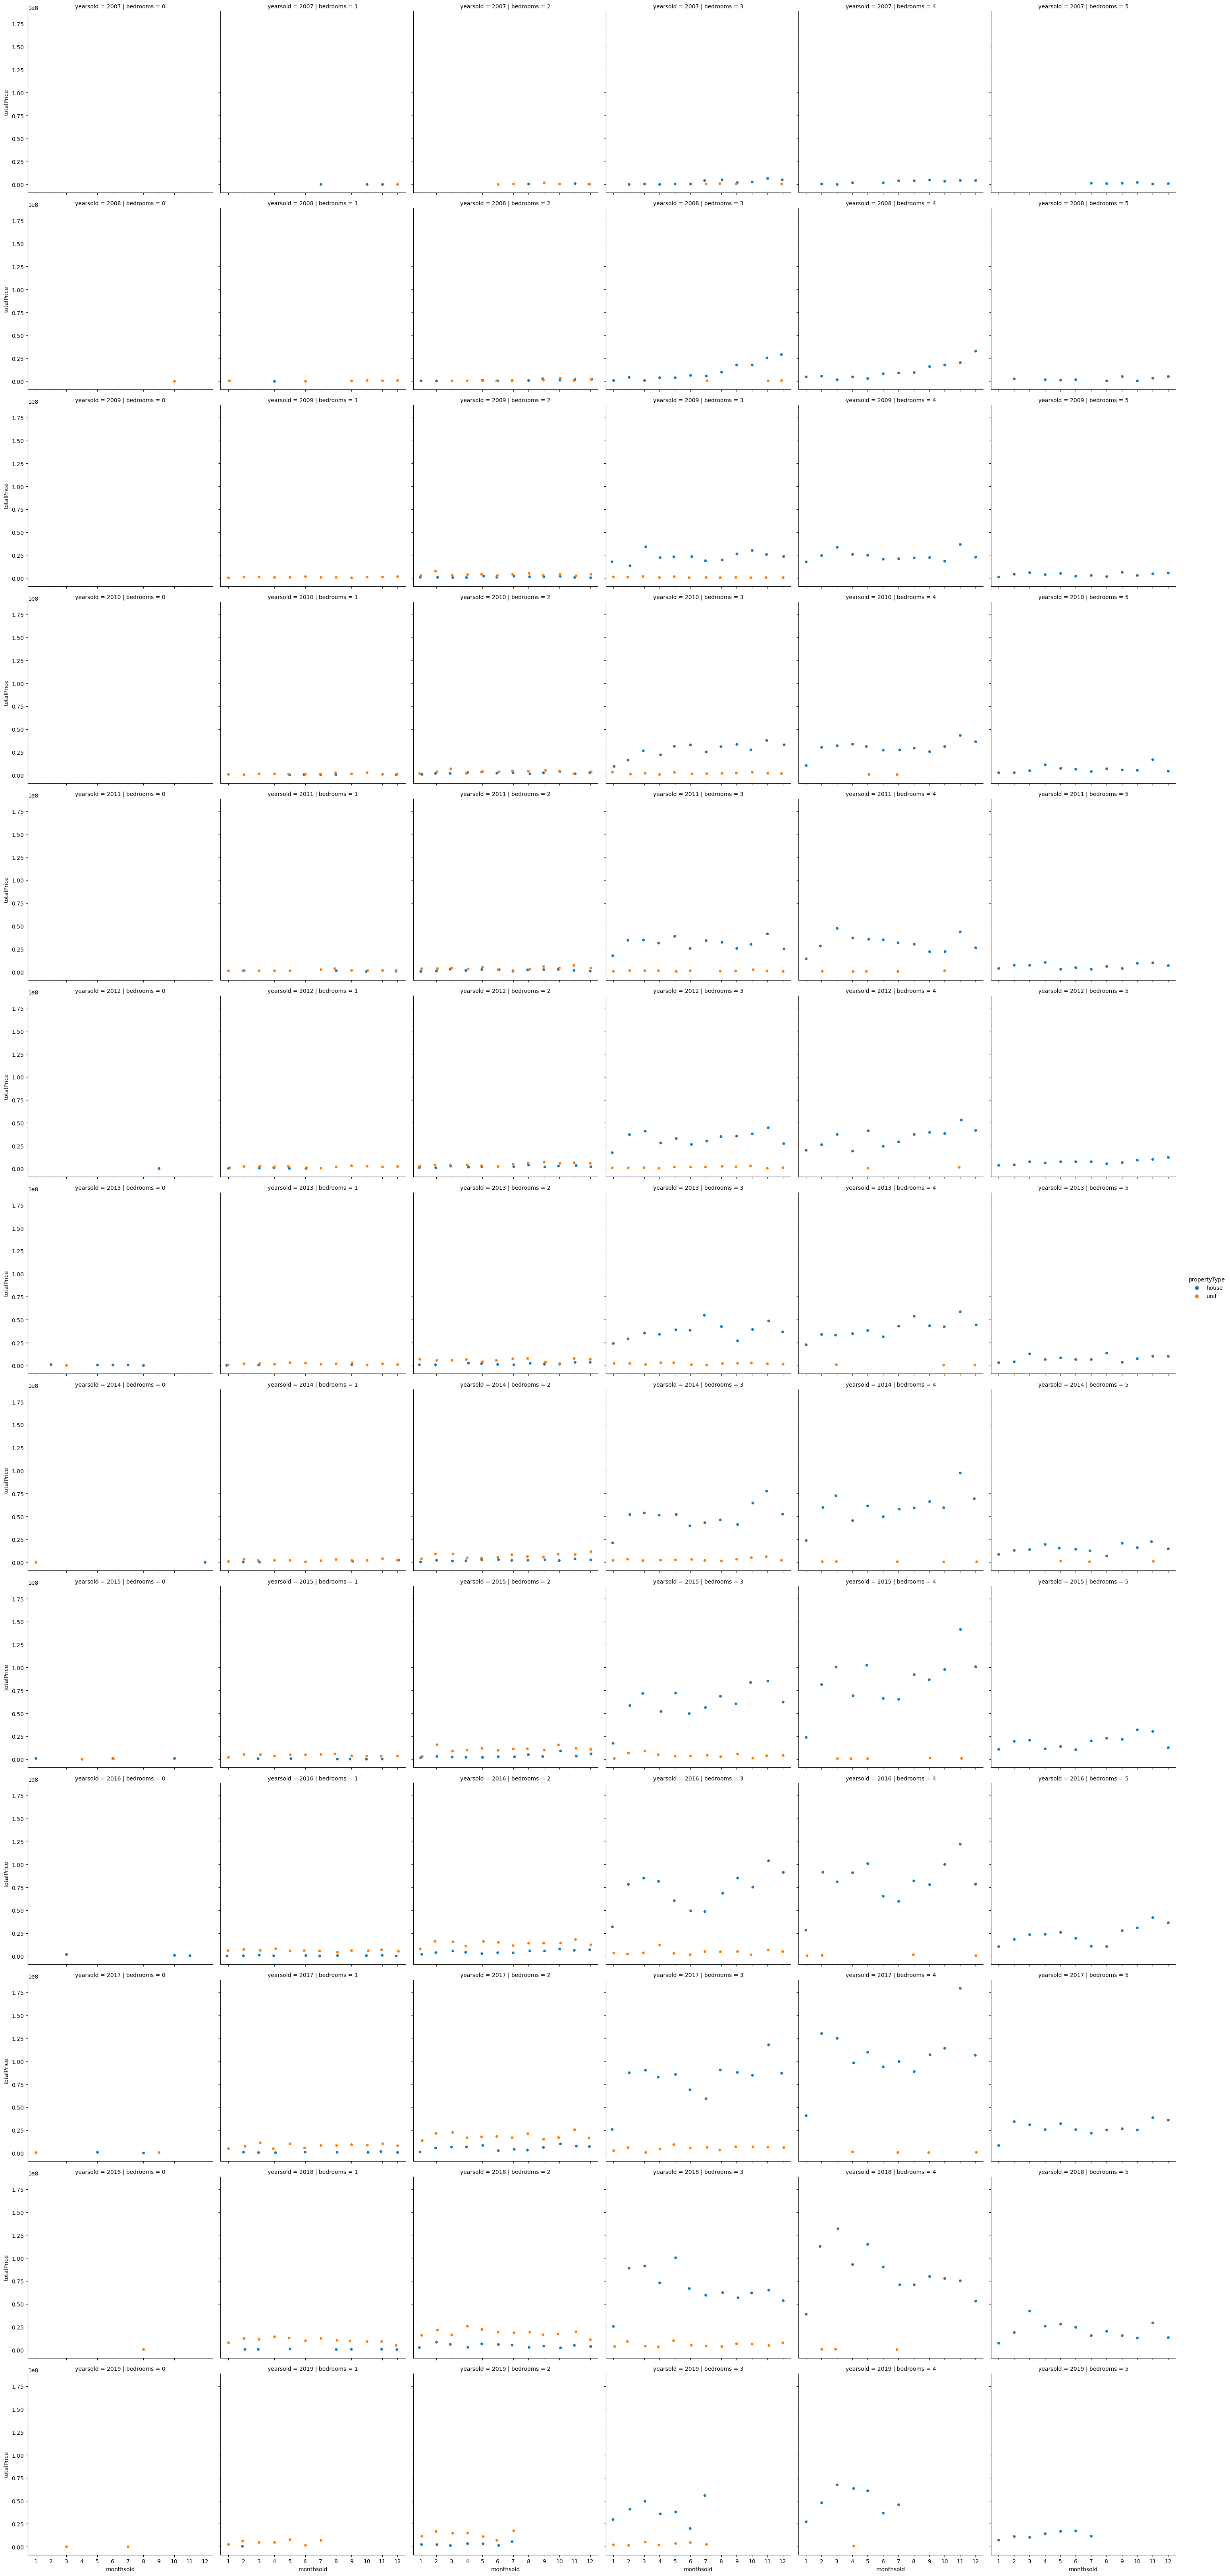

In [18]:
sns.catplot(x="monthsold", y="totalPrice",
               col="bedrooms",
               hue="propertyType",
               row="yearsold",
               data = df_sales_monthly)
     

We can see there is a tendency of increasing the price values in the February and March, and in November. 

In [19]:
df_daily_price = df_sales.groupby(['datesold', 'bedrooms']).agg(avgdailyprice=("price", "mean")).reset_index()
df_daily_price

,datesold,bedrooms,avgdailyprice
0,2007-02-07 00:00:00,4,"525,000.00"
1,2007-02-27 00:00:00,3,"290,000.00"
2,2007-03-07 00:00:00,3,"328,000.00"
3,2007-03-09 00:00:00,4,"380,000.00"
4,2007-03-21 00:00:00,3,"310,000.00"
...,...,...,...
10574,2019-07-26 00:00:00,2,"609,650.00"
10575,2019-07-26 00:00:00,3,"540,000.00"
10576,2019-07-26 00:00:00,4,"657,500.00"
10577,2019-07-27 00:00:00,4,"628,750.00"


In [20]:
df_monthly_price = df_sales.groupby(['monthYearsold', 'bedrooms']).agg(avgmonthlyprice=("price", "mean")).reset_index()
df_monthly_price

,monthYearsold,bedrooms,avgmonthlyprice
0,2007-02-01,3,"290,000.00"
1,2007-02-01,4,"525,000.00"
2,2007-03-01,3,"319,000.00"
3,2007-03-01,4,"380,000.00"
4,2007-04-01,3,"399,000.00"
...,...,...,...
743,2019-07-01,1,"331,261.90"
744,2019-07-01,2,"438,268.77"
745,2019-07-01,3,"600,557.73"
746,2019-07-01,4,"697,491.48"


In [21]:
df_monthly_4bedroom_price = df_monthly_price[df_monthly_price['bedrooms']==4].set_index('monthYearsold')
df_monthly_4bedroom_price

,bedrooms,avgmonthlyprice
monthYearsold,,
2007-02-01,4,"525,000.00"
2007-03-01,4,"380,000.00"
2007-04-01,4,"997,500.00"
2007-06-01,4,"710,666.67"
2007-07-01,4,"861,400.00"
...,...,...
2019-03-01,4,"816,174.70"
2019-04-01,4,"783,561.51"
2019-05-01,4,"754,035.80"


### Stationarity of Time Series

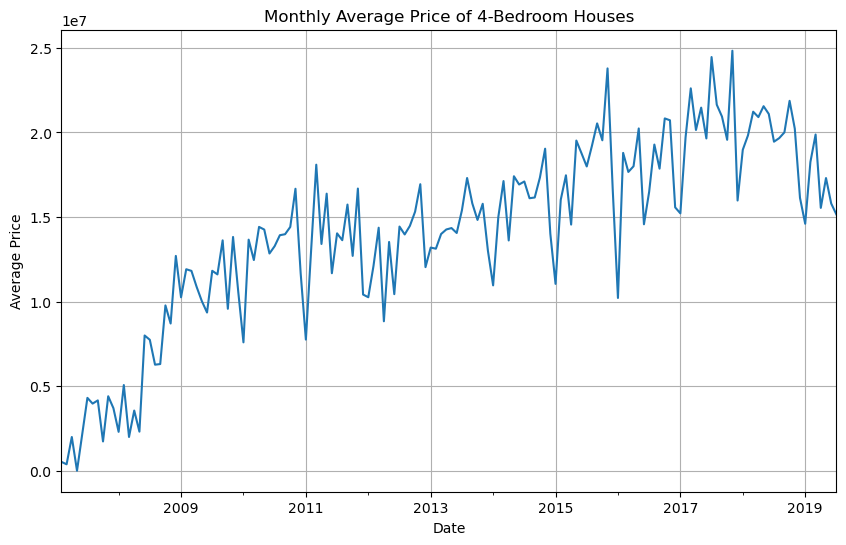

In [22]:
df_daily_price['datesold'] = pd.to_datetime(df_daily_price['datesold'])
df_4bedroom_avgprice = df_daily_price[df_daily_price['bedrooms']==4].set_index('datesold')
sales_4bedrooms = df_4bedroom_avgprice['avgdailyprice']
avg_4bedroom_sale = sales_4bedrooms.resample('M').sum()

plt.figure(figsize=(10, 6))
avg_4bedroom_sale.plot()
plt.title('Monthly Average Price of 4-Bedroom Houses')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

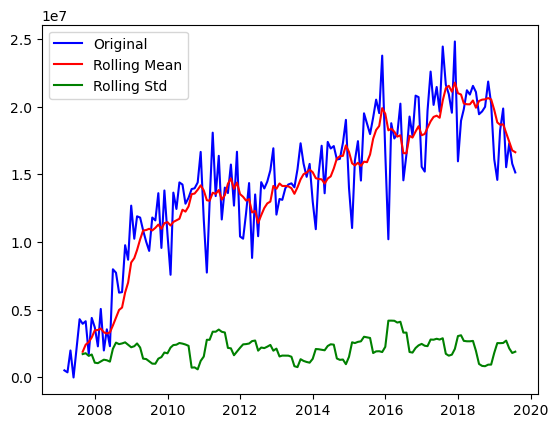

Results of Dickey-Fuller Test:
ADF Statistic: -3.057039
p-value: 0.029900
Critical Values:
1% -3.4793722137854926
5% -2.8830370378332995
10% -2.578233635380623


In [23]:

# Function to test the stationarity
def test_stationarity(timeseries):

    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('M').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('M').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('M').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
# Testing stationarity of store type a
test_stationarity(avg_4bedroom_sale)

Since the p-value is lower than alpha (0.05), we can reject the null hypothesis that is a non-stationary time series. 

So, we don't need to make any transformation.

# Model

### Train-test split

In [24]:
df_monthly_4bedroom_price.sort_values(by='monthYearsold', inplace=True)

#Determine the split criteria
split_index= int(0.7 * len(df_monthly_4bedroom_price))

#Splitting the Dataframe
train_data = df_monthly_4bedroom_price.iloc[:split_index]['avgmonthlyprice'].dropna()
test_data = df_monthly_4bedroom_price.iloc[split_index:]['avgmonthlyprice'].dropna()

### Comparing Models

In [25]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train_data,
                            trend_estimator='arima',
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test_data))
tb_mae_auto = np.mean(np.abs(test_data - predicted_output['predictions']))
tb_rmse_auto = (np.mean((test_data - predicted_output['predictions'])**2))**.5
tb_mape_auto = np.sum(np.abs(predicted_output['predictions'] - test_data)) / (np.sum((np.abs(test_data))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 5577048040.0163765
********** Round 2 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 5449262278.373751
Boosting Terminated 
Using round 2


In [26]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train_data,
                            trend_estimator=['linear', 'arima'],
                            arima_order='auto',
                            global_cost='mse')
predicted_output = boosted_model.predict(output, len(test_data))
tb_mae_linear = np.mean(np.abs(test_data - predicted_output['predictions']))
tb_rmse_linear = (np.mean((test_data - predicted_output['predictions'])**2))**.5
tb_mape_linear = np.sum(np.abs(predicted_output['predictions'] - test_data)) / (np.sum((np.abs(test_data))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 5577048040.0163765
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 4792171410.637688
Boosting Terminated 
Using round 2


In [27]:
trend_estimators=['linear', 'mean', 'median']
seasonal_estimators=['classic', 'fourier']
exogenous_estimators=['ols', 'glm']
seasonal_periods=[7, 12, 30]
fit_types=['global','local']

random_grid = {'trend_estimator': trend_estimators,
               'seasonal_estimator':seasonal_estimators,
               'exogenous_estimator': exogenous_estimators,
               'seasonal_period': seasonal_periods,
               'global_cost': 'maicc',
               'fit_type': fit_types}
pprint(random_grid)

{'exogenous_estimator': ['ols', 'glm'],
 'fit_type': ['global', 'local'],
 'global_cost': 'maicc',
 'seasonal_estimator': ['classic', 'fourier'],
 'seasonal_period': [7, 12, 30],
 'trend_estimator': ['linear', 'mean', 'median']}


In [28]:
model_results = []
for trend_estimator in trend_estimators:
  for seasonal_estimator in seasonal_estimators:
    for exogenous_estimator in exogenous_estimators:
      for seasonal_period in seasonal_periods:
        for fit_type in fit_types:
          output_tb = boosted_model.fit(train_data,
                                  trend_estimator=trend_estimator,
                                  seasonal_estimator=seasonal_estimator,
                                  exogenous_estimator=exogenous_estimator,
                                  seasonal_period=seasonal_period,
                                  global_cost='maicc',
                                  fit_type=fit_type)
          predicted_output_up = boosted_model.predict(output_tb,len(test_data))
          tb_mae_up = np.mean(np.abs(test_data - predicted_output_up['predictions']))
          tb_rmse_up = (np.mean((test_data - predicted_output_up['predictions'])**2))**.5
          tb_mape_up = np.sum(np.abs(predicted_output_up['predictions'] - test_data)) / (np.sum((np.abs(test_data))))
          model_results.append({
              "trend_estimator": trend_estimator,
              "seasonal_estimator": seasonal_estimator,
              "exogenous_estimator": exogenous_estimator,
              "seasonal_period": seasonal_period,
              "fit_type": fit_type,
              "mae":tb_mae_up,
              "rmse": tb_rmse_up,
              "mape": tb_mape_up
          })
df_results = pd.DataFrame(model_results)
df_results

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
classic(False)
cost: 2333.4696308686084
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
classic(False)
cost: 2317.661418856564
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
classic(False)
cost: 2369.838654256173
********** Round 2 **********
Using Split: 2014-12-01 00:00:00
Fitting local with trend model:
linear((1, None))
seasonal model:
classic(False)
cost: 2355.523401674411
Boosting Terminated 
Using round 2
********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
classic(False)
cost: 2328.2494302547734
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
classic(

,trend_estimator,seasonal_estimator,exogenous_estimator,seasonal_period,fit_type,mae,rmse,mape
0,linear,classic,ols,7,global,"143,539.24","143,539.24",0.00
1,linear,classic,ols,7,local,"123,876.27","123,876.27",0.00
2,linear,classic,ols,12,global,"85,285.10","85,285.10",0.00
3,linear,classic,ols,12,local,"27,629.20","27,629.20",0.00
4,linear,classic,ols,30,global,"130,388.71","130,388.71",0.00
...,...,...,...,...,...,...,...,...
67,median,fourier,glm,7,local,"206,299.97","206,299.97",0.01
68,median,fourier,glm,12,global,"165,349.16","165,349.16",0.00
69,median,fourier,glm,12,local,"153,595.13","153,595.13",0.00
70,median,fourier,glm,30,global,"205,527.56","205,527.56",0.01


In [29]:
df_results.sort_values(by='mape', ascending =True).head(1)

,trend_estimator,seasonal_estimator,exogenous_estimator,seasonal_period,fit_type,mae,rmse,mape
21,linear,fourier,glm,12,local,"27,392.48","27,392.48",0.00


In [30]:
trend_estimator_sel = df_results.sort_values(by='mape', ascending =True).head(1)['trend_estimator'].values[0]
seasonal_estimator_sel = df_results.sort_values(by='mape', ascending =True).head(1)['seasonal_estimator'].values[0]
exogenous_estimator_sel = df_results.sort_values(by='mape', ascending =True).head(1)['exogenous_estimator'].values[0]
seasonal_period_sel = df_results.sort_values(by='mape', ascending =True).head(1)['seasonal_period'].values[0]
fit_type_sel = df_results.sort_values(by='mape', ascending =True).head(1)['fit_type'].values[0]

In [31]:
# Treinando o v2 Boosted Model
boosted_model_grid = tb.ThymeBoost(verbose=1)

output_grid = boosted_model_grid.fit(train_data,
                           trend_estimator=trend_estimator_sel,
                           seasonal_estimator=seasonal_estimator_sel,
                           exogenous_estimator=exogenous_estimator_sel,
                           seasonal_period=seasonal_period_sel,
                           global_cost='maicc',
                           fit_type=fit_type_sel)

predicted_output_grid = boosted_model_grid.predict(output_grid,len(test_data))
grid_mae = np.mean(np.abs(test_data - predicted_output_grid['predictions']))
grid_rmse = (np.mean((test_data - predicted_output_grid['predictions'])**2))**.5
grid_mape = np.sum(np.abs(predicted_output_grid['predictions'] - test_data)) / (np.sum((np.abs(test_data))))

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
fourier(10, False)
cost: 2364.618533923457
********** Round 2 **********
Using Split: 2008-12-01 00:00:00
Fitting local with trend model:
linear((1, None))
seasonal model:
fourier(10, False)
cost: 2344.7599930156175
Boosting Terminated 
Using round 2


In [32]:

results_data = [["Boosted Auto-Arima",tb_mape_auto, tb_rmse_auto , tb_mae_auto],
                ["Boosted Linear Auto-Arima", tb_mape_linear, tb_rmse_linear, tb_mae_linear], 
                ["Boosted Grid Model", grid_mape, grid_rmse, grid_mae]]

cols_name = ["Model", "MAPE", "RMSE", "MAE"]

# Find the index of the row with the minimum MAPE value
min_mape_index = min(range(len(results_data)), key=lambda i: results_data[i][1])

# Define ANSI escape codes for color formatting
color_start = '\033[92m'  # Green color
color_end = '\033[0m'  # Reset color

# Iterate through rows and print, coloring the row with the minimum MAPE value
for i, row in enumerate(results_data):
    if i == min_mape_index:
        # Print the row with green color
        print(color_start + tabulate([row], headers=cols_name, tablefmt="fancy_grid") + color_end)
    else:
        # Print other rows without color
        print(tabulate([row], headers=cols_name, tablefmt="fancy_grid"))

╒════════════════════╤════════════╤════════╤════════╕
│ Model              │       MAPE │   RMSE │    MAE │
╞════════════════════╪════════════╪════════╪════════╡
│ Boosted Auto-Arima │ 0.00384503 │ 136739 │ 136739 │
╘════════════════════╧════════════╧════════╧════════╛
╒═══════════════════════════╤════════════╤════════╤════════╕
│ Model                     │       MAPE │   RMSE │    MAE │
╞═══════════════════════════╪════════════╪════════╪════════╡
│ Boosted Linear Auto-Arima │ 0.00364835 │ 129744 │ 129744 │
╘═══════════════════════════╧════════════╧════════╧════════╛
╒════════════════════╤═════════════╤═════════╤═════════╕
│ Model              │        MAPE │    RMSE │     MAE │
╞════════════════════╪═════════════╪═════════╪═════════╡
│ Boosted Grid Model │ 0.000770263 │ 27392.5 │ 27392.5 │
╘════════════════════╧═════════════╧═════════╧═════════╛


According to the KPIs above, we can see that Boosted Grid Model performed better, since it`s mean absolute percentage error is lower than the other models.

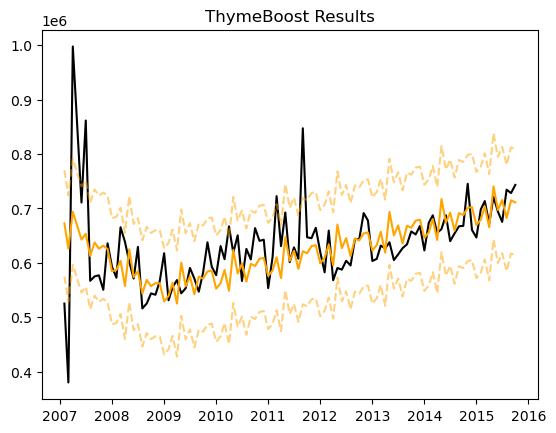

In [33]:
boosted_model_grid.plot_results(pd.concat([output_grid,predicted_output_grid]))

### Selecting the model

In [34]:
all_data = pd.concat([train_data.dropna(),test_data.dropna()])
all_data

monthYearsold
2007-02-01   525,000.00
2007-03-01   380,000.00
2007-04-01   997,500.00
2007-06-01   710,666.67
2007-07-01   861,400.00
                ...    
2019-03-01   816,174.70
2019-04-01   783,561.51
2019-05-01   754,035.80
2019-06-01   787,601.06
2019-07-01   697,491.48
Name: avgmonthlyprice, Length: 149, dtype: float64

In [35]:
all_data = all_data.reset_index()
all_data['monthYearsold'] = pd.to_datetime(all_data['monthYearsold'])
monthly_data = all_data.resample('M', on='monthYearsold').sum()

In [36]:
monthly_data.index = pd.DatetimeIndex(monthly_data.index)

In [37]:
monthly_data

,avgmonthlyprice
monthYearsold,
2007-02-28,"525,000.00"
2007-03-31,"380,000.00"
2007-04-30,"997,500.00"
2007-05-31,0.00
2007-06-30,"710,666.67"
...,...
2019-03-31,"816,174.70"
2019-04-30,"783,561.51"
2019-05-31,"754,035.80"


In [38]:
boosted_model_selected = tb.ThymeBoost(verbose=1)
output_selected  = boosted_model_selected.fit(monthly_data['avgmonthlyprice'],
                           trend_estimator=trend_estimator_sel,
                           seasonal_estimator=seasonal_estimator_sel,
                           exogenous_estimator=exogenous_estimator_sel,
                           seasonal_period=seasonal_period_sel,
                           global_cost='maicc',
                           fit_type=fit_type_sel)
# Specifying the future days to predict
num_future_steps = 24

# Putting in the model
future_output = boosted_model_selected.predict(output_selected, num_future_steps)

# Extract the predictions for the future time points
future_predictions = future_output['predictions']

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
fourier(10, False)
cost: 3528.717323801385
********** Round 2 **********
Using Split: 2011-02-28 00:00:00
Fitting local with trend model:
linear((1, None))
seasonal model:
fourier(10, False)
cost: 3419.615189009135
Boosting Terminated 
Using round 2


In [39]:
output_selected = output_selected.rename(columns = {"y" : "predictions",
                                                    "yhat" : "predicted_exogenous",
                                                    "yhat_upper": "predicted_upper",
                                                    "yhat_lower": "predicted_lower",
                                                    "seasonality": "predicted_seasonality",
                                                    "trend": "predicted_trend"})
output_selected = output_selected[["predictions", "predicted_trend", "predicted_seasonality", "predicted_exogenous","predicted_upper", "predicted_lower"]]
output_selected

,predictions,predicted_trend,predicted_seasonality,predicted_exogenous,predicted_upper,predicted_lower
monthYearsold,,,,,,
2007-02-28,"525,000.00","566,227.57","-1,906.46","564,321.11","712,695.39","415,946.83"
2007-03-31,"380,000.00","567,206.13","6,598.15","573,804.28","722,178.56","425,430.00"
2007-04-30,"997,500.00","568,184.69","39,066.70","607,251.39","755,625.67","458,877.10"
2007-05-31,0.00,"569,163.25","-43,488.85","525,674.39","674,048.67","377,300.11"
2007-06-30,"710,666.67","570,141.80","-4,529.28","565,612.52","713,986.80","417,238.24"
...,...,...,...,...,...,...
2019-03-31,"816,174.70","815,959.59","6,598.15","822,557.73","970,932.02","674,183.45"
2019-04-30,"783,561.51","818,060.00","39,066.70","857,126.70","1,005,500.98","708,752.41"
2019-05-31,"754,035.80","820,160.41","-43,488.85","776,671.55","925,045.83","628,297.27"


In [40]:
future_predictions

2019-08-31   805,263.24
2019-09-30   837,351.37
2019-10-31   833,862.83
2019-11-30   861,721.25
2019-12-31   846,536.27
2020-01-31   805,181.16
2020-02-29   837,157.63
2020-03-31   847,762.66
2020-04-30   882,331.62
2020-05-31   801,876.47
2020-06-30   842,936.46
2020-07-31   854,158.08
2020-08-31   830,468.16
2020-09-30   862,556.29
2020-10-31   859,067.76
2020-11-30   886,926.17
2020-12-31   871,741.19
2021-01-31   830,386.08
2021-02-28   862,362.56
2021-03-31   872,967.58
2021-04-30   907,536.54
2021-05-31   827,081.40
2021-06-30   868,141.38
2021-07-31   879,363.00
Freq: M, Name: predictions, dtype: float64

In [41]:
future_output

,predictions,predicted_trend,predicted_seasonality,predicted_exogenous,predicted_upper,predicted_lower
2019-08-31,"805,263.24","826,461.64","-21,198.40",0.00,"953,637.52","656,888.96"
2019-09-30,"837,351.37","828,562.05","8,789.32",0.00,"988,822.15","685,880.58"
2019-10-31,"833,862.83","830,662.46","3,200.38",0.00,"988,430.13","679,295.54"
2019-11-30,"861,721.25","832,762.87","28,958.38",0.00,"1,019,385.05","704,057.45"
2019-12-31,"846,536.27","834,863.28","11,672.99",0.00,"1,007,296.58","685,775.96"
2020-01-31,"805,181.16","836,963.69","-31,782.53",0.00,"969,037.97","641,324.35"
2020-02-29,"837,157.63","839,064.10","-1,906.46",0.00,"1,004,110.95","670,204.31"
2020-03-31,"847,762.66","841,164.51","6,598.15",0.00,"1,017,812.48","677,712.83"
2020-04-30,"882,331.62","843,264.92","39,066.70",0.00,"1,055,477.95","709,185.28"
2020-05-31,"801,876.47","845,365.33","-43,488.85",0.00,"978,119.32","625,633.63"


In [42]:
df_all_data = pd.DataFrame(all_data)
df_all_data


,monthYearsold,avgmonthlyprice
0,2007-02-01,"525,000.00"
1,2007-03-01,"380,000.00"
2,2007-04-01,"997,500.00"
3,2007-06-01,"710,666.67"
4,2007-07-01,"861,400.00"
...,...,...
144,2019-03-01,"816,174.70"
145,2019-04-01,"783,561.51"
146,2019-05-01,"754,035.80"
147,2019-06-01,"787,601.06"


In [43]:
df_future_predictions = pd.DataFrame(future_predictions)
df_future_predictions = df_future_predictions.reset_index()
df_future_predictions = df_future_predictions.rename(columns ={"index" : "monthYearsold", "predictions": "avgmonthlyprice"})
df_future_predictions

,monthYearsold,avgmonthlyprice
0,2019-08-31,"805,263.24"
1,2019-09-30,"837,351.37"
2,2019-10-31,"833,862.83"
3,2019-11-30,"861,721.25"
4,2019-12-31,"846,536.27"
5,2020-01-31,"805,181.16"
6,2020-02-29,"837,157.63"
7,2020-03-31,"847,762.66"
8,2020-04-30,"882,331.62"
9,2020-05-31,"801,876.47"


In [44]:
df_all_wth_pred = pd.concat([df_all_data, df_future_predictions])
df_all_wth_pred

,monthYearsold,avgmonthlyprice
0,2007-02-01,"525,000.00"
1,2007-03-01,"380,000.00"
2,2007-04-01,"997,500.00"
3,2007-06-01,"710,666.67"
4,2007-07-01,"861,400.00"
...,...,...
19,2021-03-31,"872,967.58"
20,2021-04-30,"907,536.54"
21,2021-05-31,"827,081.40"
22,2021-06-30,"868,141.38"


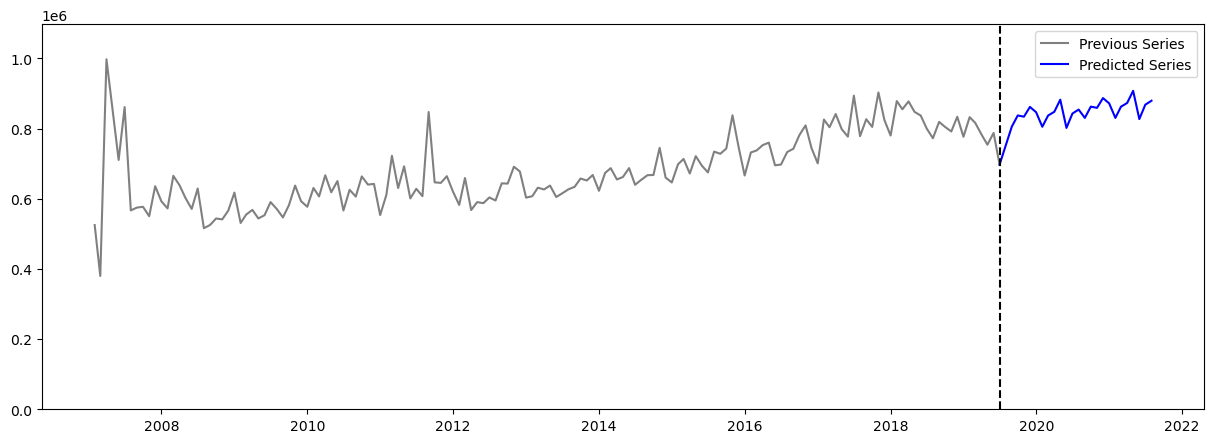

In [45]:
start_date = date(2019,7,1)
filter_date = date(2018, 1, 1)
df_all_wth_pred_index = df_all_wth_pred.set_index('monthYearsold')
base = df_all_wth_pred_index.loc[(df_all_wth_pred_index.index <= pd.to_datetime(start_date)) ]
predicted = df_all_wth_pred_index.loc[df_all_wth_pred_index.index >= pd.to_datetime(start_date)]
plt.figure(figsize=(15,5))
plt.plot(base.index, base.avgmonthlyprice, color='gray', label='Previous Series')

# Plot predicted series with a different color (e.g., red)
plt.plot(predicted.index, predicted.avgmonthlyprice, color='blue', label='Predicted Series')

# Add a vertical line at the start date with a black dashed line
plt.axvline(x=start_date, color='black', linestyle='--')

# Set y-axis limits
plt.ylim(0, max(base['avgmonthlyprice'].max(), predicted['avgmonthlyprice'].max()) * 1.1)

# Show the legend
plt.legend()

# Show the plot
plt.show()

# References

In [46]:
# https://www.kaggle.com/code/vishalgaba/arima-sarimax-time-series-forecast
# https://www.youtube.com/watch?v=DgGFhQmfxHo
# https://stackoverflow.com/questions/63488782/how-do-you-display-values-in-a-pandas-dataframe-column-with-2-decimal-places
# https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series
